In [1]:
import pickle
import numpy as np
import pandas as pd

# ----------------------------------------------------
# 1. Load traj_list.pkl
# ----------------------------------------------------
with open("traj_list.pkl", "rb") as f:
    traj_list = pickle.load(f)

print("num trajectories:", len(traj_list))
print("example element types:", type(traj_list[0][0]), type(traj_list[0][1]))
print("columns in traj 0 df:", traj_list[0][1].columns.tolist())

# ----------------------------------------------------
# 2. Compute 30-min window features in ORIGINAL units
# ----------------------------------------------------

def compute_window_features(traj_window: pd.DataFrame) -> dict:
    """
    traj_window: slice of one trajectory for a single 30-min window.
    Columns expected: t_unix, sog_knots, cog_deg.
    All outputs are in natural units (knots, deg/min, knots/hr).
    """

    sog = traj_window["sog_knots"].to_numpy(dtype=float)
    cog = traj_window["cog_deg"].to_numpy(dtype=float)
    t   = traj_window["t_unix"].to_numpy(dtype=float)

    # ----- speed features -----
    mean_sog = float(np.nanmean(sog))  # knots

    # thresholds ONLY to define fractions, not for clustering
    STOP_KNOTS = 0.5     # considered "stopped"
    SLOW_KNOTS = 5.0     # considered "slow" vs cruise

    frac_stopped = float((sog < STOP_KNOTS).mean()) if sog.size > 0 else 0.0
    frac_slow    = float((sog < SLOW_KNOTS).mean()) if sog.size > 0 else 0.0

    # ----- turning features (deg / min) -----
    if cog.size > 1:
        # unwrap heading so 359→0 doesn't look like a 359° jump
        cog_rad       = np.deg2rad(cog)
        cog_unwrapped = np.rad2deg(np.unwrap(cog_rad))

        dt_min = np.diff(t) / 60.0            # seconds -> minutes
        d_cog  = np.diff(cog_unwrapped)       # degrees
        dt_min[dt_min == 0] = np.nan

        turnrate = np.abs(d_cog / dt_min)     # deg per minute

        mean_abs_turnrate = float(np.nanmean(turnrate))
        max_heading_jump  = float(np.nanmax(np.abs(d_cog)))   # biggest heading change in deg
    else:
        mean_abs_turnrate = 0.0
        max_heading_jump  = 0.0

    # ----- acceleration features (knots / hour) -----
    if sog.size > 1:
        dt_hr = np.diff(t) / 3600.0           # seconds -> hours
        dsog  = np.diff(sog)
        dt_hr[dt_hr == 0] = np.nan

        accel = dsog / dt_hr                  # knots per hour

        mean_accel    = float(np.nanmean(accel))
        max_abs_accel = float(np.nanmax(np.abs(accel)))
    else:
        mean_accel    = 0.0
        max_abs_accel = 0.0

    return {
        "mean_sog_knots_30min": mean_sog,
        "frac_stopped_30min": frac_stopped,
        "frac_slow_30min": frac_slow,
        "mean_abs_turnrate_deg_per_min_30min": mean_abs_turnrate,
        "max_heading_jump_deg_30min": max_heading_jump,
        "mean_accel_knots_per_hr_30min": mean_accel,
        "max_abs_accel_knots_per_hr_30min": max_abs_accel,
    }


def build_windows_for_traj(traj_df: pd.DataFrame,
                           traj_index: int,
                           window_minutes: int = 30,
                           min_points: int = 2) -> pd.DataFrame:
    """
    Split one trajectory into non-overlapping 30-min windows
    and compute the 7 behaviour features for each window.
    """
    df = traj_df.sort_values("t_unix").reset_index(drop=True).copy()
    if df.empty:
        return pd.DataFrame()

    t0 = df["t_unix"].iloc[0]
    win_len_sec = window_minutes * 60

    # integer window id starting at 0
    df["window_id"] = ((df["t_unix"] - t0) // win_len_sec).astype(int)

    rows = []
    for win_id, g in df.groupby("window_id"):
        if len(g) < min_points:
            continue

        feats = compute_window_features(g)

        row = {
            "traj_index": traj_index,
            "mmsi": int(g["mmsi"].iloc[0]),
            "window_id": int(win_id),
            "start_time_unix": int(g["t_unix"].min()),
            "end_time_unix": int(g["t_unix"].max()),
            "lat_center_deg": float(g["lat_deg"].mean()),
            "lon_center_deg": float(g["lon_deg"].mean()),
        }
        row.update(feats)
        rows.append(row)

    return pd.DataFrame(rows)


# ----------------------------------------------------
# 3. Apply to all trajectories and combine
# ----------------------------------------------------
all_win_dfs = []

for traj_idx, (mmsi, traj_df) in enumerate(traj_list):
    win_df = build_windows_for_traj(traj_df, traj_idx, window_minutes=30)
    all_win_dfs.append(win_df)
    print(f"traj {traj_idx} (MMSI {mmsi}) -> {len(win_df)} windows")

traj_windows_df = pd.concat(all_win_dfs, ignore_index=True)
print("\nCombined traj_windows_df shape:", traj_windows_df.shape)

# show first 20 windows per trajectory
for traj_idx in range(len(traj_list)):
    print(f"\n=== First 20 windows for traj {traj_idx} ===")
    print(traj_windows_df[traj_windows_df["traj_index"] == traj_idx].head(20))

# ----------------------------------------------------
# 4. Save to CSV so you can inspect in Excel
# ----------------------------------------------------
traj_windows_df.to_csv("traj_windows_30min_features_orig_units.csv", index=False)
print("\nSaved to: traj_windows_30min_features_orig_units.csv")


num trajectories: 3
example element types: <class 'int'> <class 'pandas.core.frame.DataFrame'>
columns in traj 0 df: ['mmsi', 't_unix', 'lat_deg', 'lon_deg', 'sog_knots', 'cog_deg']
traj 0 (MMSI 538009560) -> 20 windows
traj 1 (MMSI 311001084.0) -> 10 windows
traj 2 (MMSI 338703000.0) -> 10 windows

Combined traj_windows_df shape: (40, 14)

=== First 20 windows for traj 0 ===
    traj_index       mmsi  window_id  start_time_unix  end_time_unix  \
0            0  538009560          0       1708855201     1708856401   
1            0  538009560          1       1708857001     1708858201   
2            0  538009560          2       1708858801     1708860001   
3            0  538009560          3       1708860601     1708861801   
4            0  538009560          4       1708862401     1708863601   
5            0  538009560          5       1708864201     1708865401   
6            0  538009560          6       1708866001     1708867201   
7            0  538009560          7       17

In [1]:
import pickle
import numpy as np
import pandas as pd

with open("traj_list.pkl", "rb") as f:
    traj_list = pickle.load(f)

print(type(traj_list), len(traj_list))
for i, (mmsi, df) in enumerate(traj_list):
    print(f"Traj {i}: MMSI={mmsi}, rows={len(df)}")
    print(df.head())
    break


<class 'list'> 3
Traj 0: MMSI=538009560, rows=60
            mmsi      t_unix    lat_deg    lon_deg  sog_knots     cog_deg
24120  538009560  1708855201  38.850735 -75.066162  10.200000  336.600006
24121  538009560  1708855801  38.890438 -75.081596  17.190908  340.518158
24122  538009560  1708856401  38.934414 -75.103600  17.300001  337.399994
24123  538009560  1708857001  38.979473 -75.127808  18.000000  337.581818
24124  538009560  1708857601  39.024929 -75.152275  17.500000  336.363647


In [2]:
# ---- constants (same style as before) ----
STOP_THRESH_NORM = 0.01    # change to your original values if different
SLOW_THRESH_NORM = 0.20    # "
SPEED_MAX = 30.0           # knots  -> sog_norm in [0,1]
COG_MAX = 360.0            # degrees -> cog_norm in [0,1]


def normalize_traj(traj_df: pd.DataFrame) -> pd.DataFrame:
    """Add sog_norm, cog_norm to original traj_df."""
    df = traj_df.copy()
    df["sog_norm"] = (df["sog_knots"] / SPEED_MAX).clip(lower=0, upper=1)
    # wrap COG to [0,360) then to [0,1]
    df["cog_deg_wrapped"] = (df["cog_deg"] % 360.0)
    df["cog_norm"] = df["cog_deg_wrapped"] / COG_MAX
    return df


def wrap_angle_unit(d_cog):
    """
    d_cog is in 'revolutions' (0..1). Wrap differences to [-0.5, 0.5]
    so jumps across 0/1 boundary are handled correctly.
    """
    d = (d_cog + 0.5) % 1.0 - 0.5
    return d


def compute_window_features_from_traj_norm(traj_window: pd.DataFrame) -> dict:
    """
    traj_window: slice of a single normalized trajectory with sog_norm, cog_norm.
    Returns the 7 behaviour features for this 30-min window.
    """
    sog_norm = traj_window["sog_norm"].values
    cog_norm = traj_window["cog_norm"].values

    # --- speed features ---
    mean_sog = float(sog_norm.mean())
    frac_stopped = float((sog_norm < STOP_THRESH_NORM).mean())
    frac_slow = float((sog_norm < SLOW_THRESH_NORM).mean())

    # --- turning features ---
    if cog_norm.size > 1:
        d_cog = np.diff(cog_norm)          # in "revolutions"
        d_cog = wrap_angle_unit(d_cog)
        dt_min = 10.0                      # data are 10-min apart
        turnrate = np.abs(d_cog) / dt_min  # rev / min
        mean_abs_turnrate = float(turnrate.mean())
        cog_spike = float(np.max(np.abs(d_cog)))
    else:
        mean_abs_turnrate = 0.0
        cog_spike = 0.0

    # --- acceleration features (from sog_norm) ---
    if sog_norm.size > 1:
        dt_hr = 10.0 / 60.0                # hours
        accel = np.diff(sog_norm) / dt_hr  # norm units per hour
        mean_accel = float(accel.mean())
        max_abs_accel = float(np.max(np.abs(accel)))
    else:
        mean_accel = 0.0
        max_abs_accel = 0.0

    return {
        "mean_sog_30min": mean_sog,
        "frac_stopped_30min": frac_stopped,
        "frac_slow_30min": frac_slow,
        "mean_abs_turnrate_norm_per_min_30min": mean_abs_turnrate,
        "cog_spike_norm_30min": cog_spike,
        "mean_accel_norm_per_hr_30min": mean_accel,
        "max_abs_accel_norm_per_hr_30min": max_abs_accel,
    }


In [3]:
def make_30min_windows(traj_df: pd.DataFrame) -> pd.DataFrame:
    """
    For ONE trajectory:
    - normalize SOG/COG
    - group into non-overlapping 30-min windows (based on t_unix)
    - compute features for each window
    Returns a DF of windows with features.
    """
    df_norm = normalize_traj(traj_df).sort_values("t_unix")

    t0 = df_norm["t_unix"].iloc[0]
    window_index = ((df_norm["t_unix"] - t0) // (30 * 60)).astype(int)

    rows = []
    for win_id, grp in df_norm.groupby(window_index):
        if len(grp) < 2:
            # too few points to get diffs; you can also skip this check
            continue
        feats = compute_window_features_from_traj_norm(grp)
        feats["traj_mmsi"] = int(grp["mmsi"].iloc[0])
        feats["traj_window_id"] = win_id
        feats["start_time_unix"] = int(grp["t_unix"].iloc[0])
        feats["end_time_unix"] = int(grp["t_unix"].iloc[-1])
        rows.append(feats)

    return pd.DataFrame(rows)


# Build for all 3 trajectories
all_windows_list = []
for idx, (mmsi, df_traj) in enumerate(traj_list):
    win_df = make_30min_windows(df_traj)
    win_df["traj_index"] = idx
    all_windows_list.append(win_df)

traj_windows_df = pd.concat(all_windows_list, ignore_index=True)
print(traj_windows_df.head(), len(traj_windows_df))


   mean_sog_30min  frac_stopped_30min  frac_slow_30min  \
0        0.496566                 0.0              0.0   
1        0.589798                 0.0              0.0   
2        0.582787                 0.0              0.0   
3        0.582128                 0.0              0.0   
4        0.580521                 0.0              0.0   

   mean_abs_turnrate_norm_per_min_30min  cog_spike_norm_30min  \
0                              0.000977              0.010884   
1                              0.000173              0.003384   
2                              0.001576              0.029799   
3                              0.000093              0.001430   
4                              0.000098              0.001360   

   mean_accel_norm_per_hr_30min  max_abs_accel_norm_per_hr_30min  traj_mmsi  \
0                      0.710000                         1.398182  538009560   
1                     -0.041818                         0.100000  538009560   
2                      

In [4]:
def make_30min_windows(traj_df: pd.DataFrame) -> pd.DataFrame:
    """
    For ONE trajectory:
    - normalize SOG/COG
    - group into non-overlapping 30-min windows (based on t_unix)
    - compute features for each window
    - also attach mmsi + window-center lat/lon
    """
    df_norm = normalize_traj(traj_df).sort_values("t_unix")

    t0 = df_norm["t_unix"].iloc[0]
    window_index = ((df_norm["t_unix"] - t0) // (30 * 60)).astype(int)

    rows = []
    for win_id, grp in df_norm.groupby(window_index):
        if len(grp) < 2:
            continue

        feats = compute_window_features_from_traj_norm(grp)

        # --- metadata per window ---
        mmsi = int(grp["mmsi"].iloc[0])
        lat_center_deg = float(grp["lat_deg"].mean())
        lon_center_deg = float(grp["lon_deg"].mean())
        start_time = int(grp["t_unix"].iloc[0])
        end_time   = int(grp["t_unix"].iloc[-1])

        feats.update({
            "mmsi": mmsi,
            "lat_center_deg": lat_center_deg,
            "lon_center_deg": lon_center_deg,
            "traj_window_id": win_id,
            "start_time_unix": start_time,
            "end_time_unix": end_time,
        })
        rows.append(feats)

    return pd.DataFrame(rows)


In [5]:
all_windows_list = []
for idx, (mmsi, df_traj) in enumerate(traj_list):
    win_df = make_30min_windows(df_traj)
    win_df["traj_index"] = idx      # keep which trajectory it came from
    all_windows_list.append(win_df)

traj_windows_df = pd.concat(all_windows_list, ignore_index=True)

print(traj_windows_df.head())


   mean_sog_30min  frac_stopped_30min  frac_slow_30min  \
0        0.496566                 0.0              0.0   
1        0.589798                 0.0              0.0   
2        0.582787                 0.0              0.0   
3        0.582128                 0.0              0.0   
4        0.580521                 0.0              0.0   

   mean_abs_turnrate_norm_per_min_30min  cog_spike_norm_30min  \
0                              0.000977              0.010884   
1                              0.000173              0.003384   
2                              0.001576              0.029799   
3                              0.000093              0.001430   
4                              0.000098              0.001360   

   mean_accel_norm_per_hr_30min  max_abs_accel_norm_per_hr_30min       mmsi  \
0                      0.710000                         1.398182  538009560   
1                     -0.041818                         0.100000  538009560   
2                      

In [8]:
kmeans_cent = pd.read_excel("centroids.xlsx", sheet_name="kmeans_k6").set_index("kmeans_k6_cluster")
hc_cent     = pd.read_excel("centroids.xlsx", sheet_name="hc_k6").set_index("hc_k6_cluster")
gmm_cent    = pd.read_excel("centroids.xlsx", sheet_name="gmm_k7").set_index("gmm_k7_cluster")


In [10]:
feature_cols = [
    "mean_sog_30min",
    "frac_stopped_30min",
    "frac_slow_30min",
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]


In [9]:
import numpy as np

def assign_by_nearest_centroid(X_df, centroids_df, feature_cols):
    """
    X_df: dataframe of windows (traj_windows_df)
    centroids_df: kmeans_cent / hc_cent / gmm_cent
    feature_cols: list of feature column names (same order in both dfs)
    """
    X = X_df[feature_cols].to_numpy(dtype=float)                # (N, F)
    C = centroids_df[feature_cols].to_numpy(dtype=float)        # (K, F)

    # squared Euclidean distance to each centroid
    diff = X[:, None, :] - C[None, :, :]    # (N, K, F)
    d2 = np.sum(diff**2, axis=2)            # (N, K)
    labels = np.argmin(d2, axis=1)          # (N,)
    return labels


In [11]:
traj_windows_df["kmeans_k6_label"] = assign_by_nearest_centroid(
    traj_windows_df, kmeans_cent, feature_cols
)

traj_windows_df["hc_k6_label"] = assign_by_nearest_centroid(
    traj_windows_df, hc_cent, feature_cols
)

traj_windows_df["gmm_k7_label"] = assign_by_nearest_centroid(
    traj_windows_df, gmm_cent, feature_cols
)


In [13]:
print(traj_windows_df[[
    "mmsi", "traj_window_id",
    "kmeans_k6_label", "hc_k6_label", "gmm_k7_label"
]].head())

print("Counts KMeans:", traj_windows_df["kmeans_k6_label"].value_counts().sort_index())
print("Counts HC    :", traj_windows_df["hc_k6_label"].value_counts().sort_index())
print("Counts GMM   :", traj_windows_df["gmm_k7_label"].value_counts().sort_index())


        mmsi  traj_window_id  kmeans_k6_label  hc_k6_label  gmm_k7_label
0  538009560               0                3            2             3
1  538009560               1                0            3             0
2  538009560               2                0            3             0
3  538009560               3                0            3             0
4  538009560               4                0            3             0
Counts KMeans: kmeans_k6_label
0    29
2     2
3     2
4     4
5     3
Name: count, dtype: int64
Counts HC    : hc_k6_label
0     2
1     4
2     2
3    29
5     3
Name: count, dtype: int64
Counts GMM   : gmm_k7_label
0    22
2     1
3     2
4     1
5     3
6    11
Name: count, dtype: int64


In [14]:
traj_windows_df.to_csv("traj_windows_with_clusters.csv", index=False)
print("Saved windows with KMeans/HC/GMM labels to traj_windows_with_clusters.csv")


Saved windows with KMeans/HC/GMM labels to traj_windows_with_clusters.csv


In [15]:
kmeans_cluster_to_behavior = {
    0: "cruise_fast_steady",
    1: "stopped_static",
    2: "loiter_turning",
    3: "transit_accelerating",
    4: "transit_decelerating",
    5: "slow_cruise_loiter",
}

hc_cluster_to_behavior = {
    0: "loiter_turning",
    1: "transit_decelerating",
    2: "transit_accelerating",
    3: "cruise_fast_steady",
    4: "stopped_static",
    5: "slow_cruise_loiter",
}

gmm_cluster_to_behavior = {
    0: "cruise_fast_steady",
    1: "stopped_static",
    2: "loiter_sharp_turns",
    3: "transit_accelerating_maneuver",
    4: "loiter_decelerating_maneuver",
    5: "slow_cruise_steady",
    6: "cruise_decelerating_turning",
}


In [18]:
import pandas as pd

# 1. Load the windows file
df = pd.read_csv("traj_windows_with_clusters.csv")

# 2. Add behavior label columns using .map()
df["kmeans_behavior"] = df["kmeans_k6_label"].map(kmeans_cluster_to_behavior)
df["hc_behavior"]      = df["hc_k6_label"].map(hc_cluster_to_behavior)
df["gmm_behavior"]     = df["gmm_k7_label"].map(gmm_cluster_to_behavior)

# (optional) quick sanity check
print(df[[
    "kmeans_k6_label", "kmeans_behavior",
    "hc_k6_label",     "hc_behavior",
    "gmm_k7_label",    "gmm_behavior"
]].head())

# 3. Save to a new CSV (so you keep the old one if needed)
df.to_csv("traj_windows_with_clusters_and_behaviors.csv", index=False)
print("Saved to traj_windows_with_clusters_and_behaviors.csv")


   kmeans_k6_label       kmeans_behavior  hc_k6_label           hc_behavior  \
0                3  transit_accelerating            2  transit_accelerating   
1                0    cruise_fast_steady            3    cruise_fast_steady   
2                0    cruise_fast_steady            3    cruise_fast_steady   
3                0    cruise_fast_steady            3    cruise_fast_steady   
4                0    cruise_fast_steady            3    cruise_fast_steady   

   gmm_k7_label                   gmm_behavior  
0             3  transit_accelerating_maneuver  
1             0             cruise_fast_steady  
2             0             cruise_fast_steady  
3             0             cruise_fast_steady  
4             0             cruise_fast_steady  
Saved to traj_windows_with_clusters_and_behaviors.csv


Windows in trajectory (MMSI 538009560): 20


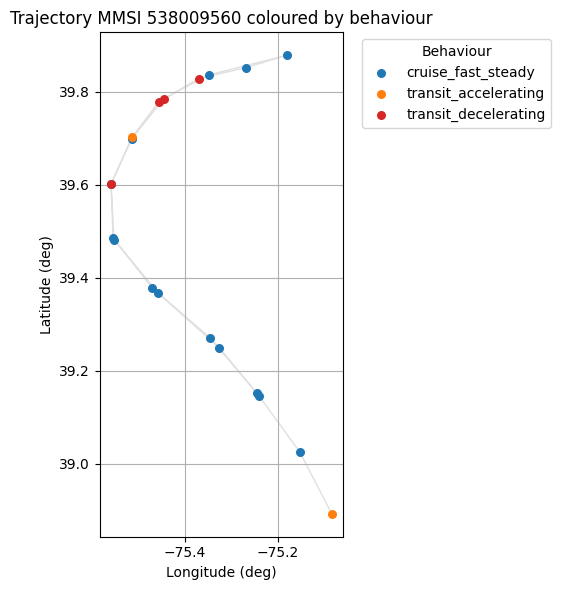

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load window + behaviour data
# -----------------------------
df = pd.read_csv("traj_windows_with_clusters_and_behaviors.csv")

# Make sure these column names match your file:
# - lat_center_deg
# - lon_center_deg
# - traj_mmsi
# - start_time_unix
# - kmeans_behavior / hc_behavior / gmm_behavior

# -----------------------------
# 2. Choose which trajectory and which behaviour model
# -----------------------------
mmsi_to_plot   = 538009560          # <--- change to whichever MMSI you want
behavior_col   = "kmeans_behavior"  # or "hc_behavior" or "gmm_behavior"

traj = (
    df[df["mmsi"] == mmsi_to_plot]
    .sort_values("start_time_unix")
    .reset_index(drop=True)
)

print(f"Windows in trajectory (MMSI {mmsi_to_plot}):", len(traj))

# -----------------------------
# 3. Color map for behaviours
# -----------------------------
color_map = {
    "cruise_fast_steady":          "tab:blue",
    "slow_cruise_loiter":          "tab:cyan",
    "slow_cruise_steady":          "tab:cyan",
    "transit_accelerating":        "tab:orange",
    "transit_decelerating":        "tab:red",
    "transit_accelerating_maneuver": "tab:orange",
    "loiter_turning":              "tab:purple",
    "loiter_sharp_turns":          "tab:purple",
    "loiter_decelerating_maneuver":"tab:pink",
    "cruise_decelerating_turning": "tab:brown",
    "stopped_static":              "tab:green",
}

# -----------------------------
# 4. Plot lon vs lat, coloured by behaviour
# -----------------------------
plt.figure(figsize=(8, 6))

# Optional: draw the whole track in light grey in the background
plt.plot(
    traj["lon_center_deg"], traj["lat_center_deg"],
    color="lightgray", linewidth=1, zorder=0, alpha=0.7
)

# Scatter points, one colour per behaviour
for beh, group in traj.groupby(behavior_col):
    plt.scatter(
        group["lon_center_deg"],
        group["lat_center_deg"],
        s=30,
        color=color_map.get(beh, "k"),   # default 'k' if behaviour not in map
        label=beh,
        zorder=5
    )

plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title(f"Trajectory MMSI {mmsi_to_plot} coloured by behaviour")
plt.legend(title="Behaviour", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.gca().set_aspect("equal", "box")  # keep geographic aspect ratio
plt.tight_layout()
plt.show()


Windows in trajectory (MMSI 311001084): 10


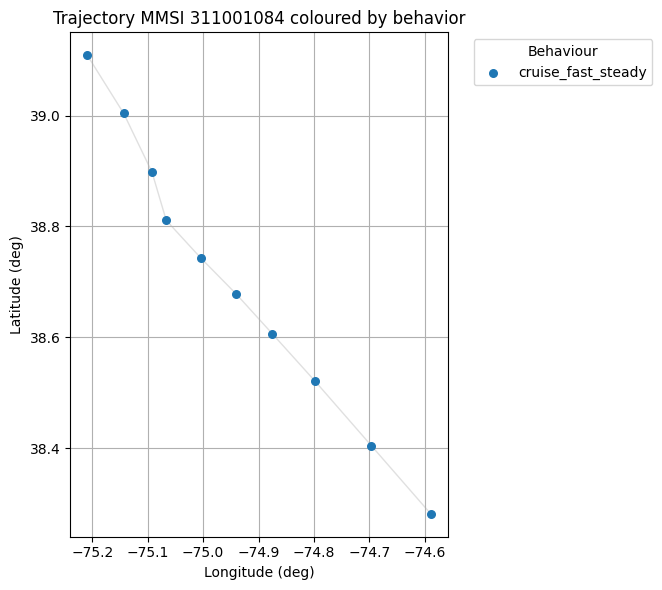

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load window + behaviour data
# -----------------------------
df = pd.read_csv("traj_windows_with_clusters_and_behaviors.csv")

# Make sure these column names match your file:
# - lat_center_deg
# - lon_center_deg
# - traj_mmsi
# - start_time_unix
# - kmeans_behavior / hc_behavior / gmm_behavior

# -----------------------------
# 2. Choose which trajectory and which behaviour model
# -----------------------------
mmsi_to_plot   = 311001084        # <--- change to whichever MMSI you want
behavior_col   = "kmeans_behavior"  # or "hc_behavior" or "gmm_behavior"

traj = (
    df[df["mmsi"] == mmsi_to_plot]
    .sort_values("start_time_unix")
    .reset_index(drop=True)
)

print(f"Windows in trajectory (MMSI {mmsi_to_plot}):", len(traj))

# -----------------------------
# 3. Color map for behaviours
# -----------------------------
color_map = {
    "cruise_fast_steady":          "tab:blue",
    "slow_cruise_loiter":          "tab:cyan",
    "slow_cruise_steady":          "tab:cyan",
    "transit_accelerating":        "tab:orange",
    "transit_decelerating":        "tab:red",
    "transit_accelerating_maneuver": "tab:orange",
    "loiter_turning":              "tab:purple",
    "loiter_sharp_turns":          "tab:purple",
    "loiter_decelerating_maneuver":"tab:pink",
    "cruise_decelerating_turning": "tab:brown",
    "stopped_static":              "tab:green",
}

# -----------------------------
# 4. Plot lon vs lat, coloured by behaviour
# -----------------------------
plt.figure(figsize=(8, 6))

# Optional: draw the whole track in light grey in the background
plt.plot(
    traj["lon_center_deg"], traj["lat_center_deg"],
    color="lightgray", linewidth=1, zorder=0, alpha=0.7
)

# Scatter points, one colour per behaviour
for beh, group in traj.groupby(behavior_col):
    plt.scatter(
        group["lon_center_deg"],
        group["lat_center_deg"],
        s=30,
        color=color_map.get(beh, "k"),   # default 'k' if behaviour not in map
        label=beh,
        zorder=5
    )

plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title(f"Trajectory MMSI {mmsi_to_plot} coloured by behavior")
plt.legend(title="Behaviour", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.gca().set_aspect("equal", "box")  # keep geographic aspect ratio
plt.tight_layout()
plt.show()


Windows in trajectory (MMSI 338703000): 10


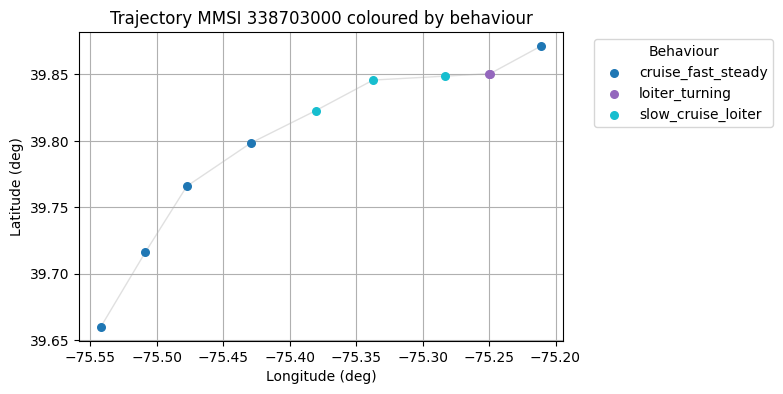

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load window + behaviour data
# -----------------------------
df = pd.read_csv("traj_windows_with_clusters_and_behaviors.csv")

# Make sure these column names match your file:
# - lat_center_deg
# - lon_center_deg
# - traj_mmsi
# - start_time_unix
# - kmeans_behavior / hc_behavior / gmm_behavior

# -----------------------------
# 2. Choose which trajectory and which behaviour model
# -----------------------------
mmsi_to_plot   = 338703000       # <--- change to whichever MMSI you want
behavior_col   = "kmeans_behavior"  # or "hc_behavior" or "gmm_behavior"

traj = (
    df[df["mmsi"] == mmsi_to_plot]
    .sort_values("start_time_unix")
    .reset_index(drop=True)
)

print(f"Windows in trajectory (MMSI {mmsi_to_plot}):", len(traj))

# -----------------------------
# 3. Color map for behaviours
# -----------------------------
color_map = {
    "cruise_fast_steady":          "tab:blue",
    "slow_cruise_loiter":          "tab:cyan",
    "slow_cruise_steady":          "tab:cyan",
    "transit_accelerating":        "tab:orange",
    "transit_decelerating":        "tab:red",
    "transit_accelerating_maneuver": "tab:orange",
    "loiter_turning":              "tab:purple",
    "loiter_sharp_turns":          "tab:purple",
    "loiter_decelerating_maneuver":"tab:pink",
    "cruise_decelerating_turning": "tab:brown",
    "stopped_static":              "tab:green",
}

# -----------------------------
# 4. Plot lon vs lat, coloured by behaviour
# -----------------------------
plt.figure(figsize=(8, 6))

# Optional: draw the whole track in light grey in the background
plt.plot(
    traj["lon_center_deg"], traj["lat_center_deg"],
    color="lightgray", linewidth=1, zorder=0, alpha=0.7
)

# Scatter points, one colour per behaviour
for beh, group in traj.groupby(behavior_col):
    plt.scatter(
        group["lon_center_deg"],
        group["lat_center_deg"],
        s=30,
        color=color_map.get(beh, "k"),   # default 'k' if behaviour not in map
        label=beh,
        zorder=5
    )

plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title(f"Trajectory MMSI {mmsi_to_plot} coloured by behaviour")
plt.legend(title="Behaviour", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.gca().set_aspect("equal", "box")  # keep geographic aspect ratio
plt.tight_layout()
plt.show()


In [ ]:
#below is the main final function that takes tuples and give the behaviour plots.
#up cells are experiments 
#you need a csv with three sheets each having centroids of different clustering methods.
#we also need the traj_list.pkl to input . and the the fuction does feature engineering and gives the output of latvs long trajectories graphs colored by behaviour.

In [1]:
import pickle
import os
from typing import List, Tuple, Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 1.  Behavior label mappings (you already defined these)
# -----------------------------------------------------------

kmeans_cluster_to_behavior = {
    0: "cruise_fast_steady",
    1: "stopped_static",
    2: "loiter_turning",
    3: "transit_accelerating",
    4: "transit_decelerating",
    5: "slow_cruise_loiter",
}

hc_cluster_to_behavior = {
    0: "loiter_turning",
    1: "transit_decelerating",
    2: "transit_accelerating",
    3: "cruise_fast_steady",
    4: "stopped_static",
    5: "slow_cruise_loiter",
}

gmm_cluster_to_behavior = {
    0: "cruise_fast_steady",
    1: "stopped_static",
    2: "loiter_sharp_turns",
    3: "transit_accelerating_maneuver",
    4: "loiter_decelerating_maneuver",
    5: "slow_cruise_steady",
    6: "cruise_decelerating_turning",
}


# -----------------------------------------------------------
# 2.  Helper: wrap angle differences in "revolutions" [-0.5, 0.5]
# -----------------------------------------------------------

def wrap_angle_unit(d_cog: np.ndarray) -> np.ndarray:
    """
    d_cog is difference of normalized COG (0..1). We want the shortest
    wrap-around difference in range [-0.5, 0.5] (i.e., -180..180 deg / 360).
    """
    return ((d_cog + 0.5) % 1.0) - 0.5


# -----------------------------------------------------------
# 3.  Compute 7 window features from a raw (UN-normalized) window DF
#     (this reproduces your original normalized-feature logic)
# -----------------------------------------------------------

def compute_window_features(win_df: pd.DataFrame) -> Dict[str, float]:
    """
    win_df: slice of one trajectory, original units:
      columns must include ['sog_knots','cog_deg'].
    Returns dict with the 7 behaviour features, using the SAME
    normalization / thresholds as your clustering pipeline.
    """
    # ---- constants (must match your training pipeline) ----
    SPEED_MAX = 30.0                 # knots -> sog_norm in [0,1]
    STOP_KNOTS = 0.5
    SLOW_KNOTS = 5.0
    STOP_THRESH_NORM = STOP_KNOTS / SPEED_MAX
    SLOW_THRESH_NORM = SLOW_KNOTS / SPEED_MAX

    # ---- speed features (use normalized SOG 0..1) ----
    sog_knots = win_df["sog_knots"].astype(float).to_numpy()
    sog_norm = np.clip(sog_knots / SPEED_MAX, 0.0, 1.0)

    mean_sog = float(sog_norm.mean())
    frac_stopped = float((sog_norm < STOP_THRESH_NORM).mean())
    frac_slow = float((sog_norm < SLOW_THRESH_NORM).mean())

    # ---- turning features using normalized COG 0..1 ----
    cog_deg = win_df["cog_deg"].astype(float).to_numpy()
    cog_norm = (cog_deg % 360.0) / 360.0

    if cog_norm.size > 1:
        d_cog = np.diff(cog_norm)
        d_cog = wrap_angle_unit(d_cog)  # in "revolutions"

        # sampling is at 10-min resolution in your preprocessing
        dt_min = 10.0
        turnrate = np.abs(d_cog) / dt_min  # revolutions per minute

        mean_abs_turnrate = float(turnrate.mean())
        cog_spike = float(np.max(np.abs(d_cog)))  # biggest normalized jump per step
    else:
        mean_abs_turnrate = 0.0
        cog_spike = 0.0

    # ---- acceleration features from normalized SOG ----
    if sog_norm.size > 1:
        dt_hr = 10.0 / 60.0  # 10 minutes in hours
        accel = np.diff(sog_norm) / dt_hr  # norm units per hour

        mean_accel = float(accel.mean())
        max_abs_accel = float(np.max(np.abs(accel)))
    else:
        mean_accel = 0.0
        max_abs_accel = 0.0

    return {
        "mean_sog_30min": mean_sog,
        "frac_stopped_30min": frac_stopped,
        "frac_slow_30min": frac_slow,
        "mean_abs_turnrate_norm_per_min_30min": mean_abs_turnrate,
        "cog_spike_norm_30min": cog_spike,
        "mean_accel_norm_per_hr_30min": mean_accel,
        "max_abs_accel_norm_per_hr_30min": max_abs_accel,
    }


# -----------------------------------------------------------
# 4.  Build windows + features for one trajectory DF
# -----------------------------------------------------------

def build_windows_for_traj(traj_df: pd.DataFrame,
                           traj_index: int,
                           window_minutes: int = 30,
                           step_minutes: int = 10) -> List[Dict[str, Any]]:
    """
    Non-overlapping or sliding windows along t_unix.
    Assumes traj_df sorted by t_unix.
    Returns list of dicts, each containing features + metadata.
    """
    traj_df = traj_df.sort_values("t_unix").reset_index(drop=True)
    t_vals = traj_df["t_unix"].to_numpy().astype(int)

    if len(t_vals) == 0:
        return []

    w_sec = window_minutes * 60
    step_sec = step_minutes * 60

    t_start = t_vals[0]
    t_end_max = t_vals[-1]

    mmsi = int(traj_df["mmsi"].iloc[0])

    windows: List[Dict[str, Any]] = []
    window_id = 0

    while t_start + w_sec <= t_end_max:
        t_end = t_start + w_sec
        mask = (t_vals >= t_start) & (t_vals < t_end)
        win_df = traj_df.loc[mask]

        # Need at least 2 points to compute diffs
        if len(win_df) >= 2:
            feats = compute_window_features(win_df)

            feats.update({
                "traj_window_id": window_id,
                "start_time_unix": int(t_start),
                "end_time_unix": int(t_end),
                "traj_index": traj_index,
                "traj_mmsi": mmsi,
                "lat_center_deg": float(win_df["lat_deg"].mean()),
                "lon_center_deg": float(win_df["lon_deg"].mean()),
            })

            windows.append(feats)
            window_id += 1

        t_start += step_sec

    return windows


# -----------------------------------------------------------
# 5.  Main pipeline function (this is what you call)
# -----------------------------------------------------------

def run_behavior_pipeline(traj_pkl_path: str,
                          centroids_excel_path: str = "centroids.xlsx",
                          output_csv: str = "traj_windows_with_behaviors.csv",
                          output_plot_dir: str = "behavior_plots") -> pd.DataFrame:
    """
    1. Load traj_list.pkl ([(mmsi, traj_df), ...])
    2. Build 30-min windows + features for ALL trajectories
    3. Load centroids for kmeans, HC, GMM from centroids.xlsx
       (sheets: 'kmeans_k6', 'hc_k6', 'gmm_k7')
    4. Assign clusters + behavior labels
    5. Save CSV and trajectory plots (lat vs lon colored by behavior)

    Returns the full windows DataFrame.
    """

    os.makedirs(output_plot_dir, exist_ok=True)

    # ---------- load trajectories ----------
    with open(traj_pkl_path, "rb") as f:
        traj_list: List[Tuple[int, pd.DataFrame]] = pickle.load(f)

    all_windows: List[Dict[str, Any]] = []
    for traj_idx, (mmsi, traj_df) in enumerate(traj_list):
        windows = build_windows_for_traj(traj_df, traj_idx)
        all_windows.extend(windows)

    traj_windows_df = pd.DataFrame(all_windows)
    if traj_windows_df.empty:
        print("No windows built. Check trajectories / time ranges.")
        return traj_windows_df

    # ---------- load centroids ----------
    kmeans_cent = (
        pd.read_excel(centroids_excel_path, sheet_name="kmeans_k6")
        .set_index("kmeans_k6_cluster")
    )
    hc_cent = (
        pd.read_excel(centroids_excel_path, sheet_name="hc_k6")
        .set_index("hc_k6_cluster")
    )
    gmm_cent = (
        pd.read_excel(centroids_excel_path, sheet_name="gmm_k7")
        .set_index("gmm_k7_cluster")
    )

    feature_cols = [
        "mean_sog_30min",
        "frac_stopped_30min",
        "frac_slow_30min",
        "mean_abs_turnrate_norm_per_min_30min",
        "cog_spike_norm_30min",
        "mean_accel_norm_per_hr_30min",
        "max_abs_accel_norm_per_hr_30min",
    ]

    X = traj_windows_df[feature_cols].to_numpy()

    def assign_by_centroids(cent_df: pd.DataFrame) -> np.ndarray:
        C = cent_df[feature_cols].to_numpy()  # (K,7)
        # Euclidean distance to each centroid
        # X: (N,7), C: (K,7) -> dist: (N,K)
        diff = X[:, None, :] - C[None, :, :]
        dist = np.linalg.norm(diff, axis=2)
        labels = np.argmin(dist, axis=1)
        return labels

    # ---------- cluster assignments ----------
    traj_windows_df["kmeans_k6_cluster"] = assign_by_centroids(kmeans_cent)
    traj_windows_df["hc_k6_cluster"] = assign_by_centroids(hc_cent)
    traj_windows_df["gmm_k7_cluster"] = assign_by_centroids(gmm_cent)

    # ---------- map to behavior labels ----------
    traj_windows_df["kmeans_behavior"] = traj_windows_df["kmeans_k6_cluster"].map(
        kmeans_cluster_to_behavior
    )
    traj_windows_df["hc_behavior"] = traj_windows_df["hc_k6_cluster"].map(
        hc_cluster_to_behavior
    )
    traj_windows_df["gmm_behavior"] = traj_windows_df["gmm_k7_cluster"].map(
        gmm_cluster_to_behavior
    )

    # ---------- save CSV ----------
    traj_windows_df.to_csv(output_csv, index=False)
    print(f"Saved window behaviors to: {output_csv}")

    # ---------- plotting: lat vs lon, colored by behavior ----------
    def plot_for_method(method: str,
                        cluster_col: str,
                        behavior_col: str) -> None:
        for mmsi, df_vessel in traj_windows_df.groupby("traj_mmsi"):
            plt.figure(figsize=(6, 5))
            sc = plt.scatter(
                df_vessel["lon_center_deg"],
                df_vessel["lat_center_deg"],
                c=df_vessel[cluster_col],
                cmap="tab10",
                s=25,
            )
            plt.xlabel("Longitude (deg)")
            plt.ylabel("Latitude (deg)")
            plt.title(f"MMSI {mmsi} – {method} behaviors")
            
            # (cluster id -> behavior)
            behaviors = df_vessel[[cluster_col, behavior_col]].drop_duplicates()
            handles = []
            labels = []
            for cl, beh in zip(behaviors[cluster_col], behaviors[behavior_col]):
                handles.append(plt.Line2D([], [], color=sc.cmap(sc.norm(cl)),
                                          marker="o", linestyle="", markersize=6))
                labels.append(f"{cl}: {beh}")
            plt.legend(handles, labels, title="cluster: behavior", loc="best")

            fname = os.path.join(
                output_plot_dir, f"{method}_mmsi_{int(mmsi)}.png"
            )
            plt.tight_layout()
            plt.savefig(fname, dpi=200)
            plt.close()
            print(f"Saved {method} plot for MMSI {mmsi} -> {fname}")

    plot_for_method("kmeans", "kmeans_k6_cluster", "kmeans_behavior")
    plot_for_method("hc", "hc_k6_cluster", "hc_behavior")
    plot_for_method("gmm", "gmm_k7_cluster", "gmm_behavior")

    return traj_windows_df


In [2]:
df_beh = run_behavior_pipeline(
    traj_pkl_path="traj_list.pkl",
    centroids_excel_path="centroids.xlsx",
    output_csv="traj_windows_with_behaviors.csv",
    output_plot_dir="behavior_plots"
)


Saved window behaviors to: traj_windows_with_behaviors.csv
Saved kmeans plot for MMSI 311001084 -> behavior_plots\kmeans_mmsi_311001084.png
Saved kmeans plot for MMSI 338703000 -> behavior_plots\kmeans_mmsi_338703000.png
Saved kmeans plot for MMSI 538009560 -> behavior_plots\kmeans_mmsi_538009560.png
Saved hc plot for MMSI 311001084 -> behavior_plots\hc_mmsi_311001084.png
Saved hc plot for MMSI 338703000 -> behavior_plots\hc_mmsi_338703000.png
Saved hc plot for MMSI 538009560 -> behavior_plots\hc_mmsi_538009560.png
Saved gmm plot for MMSI 311001084 -> behavior_plots\gmm_mmsi_311001084.png
Saved gmm plot for MMSI 338703000 -> behavior_plots\gmm_mmsi_338703000.png
Saved gmm plot for MMSI 538009560 -> behavior_plots\gmm_mmsi_538009560.png
